# Setup Environment and Prep Images


## Install TF 2.0 w/ GPU

In [1]:
!pip install -qq tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 378.8MB 58kB/s 
     |████████████████████████████████| 450kB 43.1MB/s 
     |████████████████████████████████| 61kB 27.7MB/s 
     |████████████████████████████████| 4.1MB 45.1MB/s 


In [2]:
# if no GPU is found press Runtime (in the menu at the top) and choose "Change Runtime Type" to GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# Import tools
import numpy as np
import pandas as pd
import itertools as IT
import matplotlib.pyplot as plt
import csv
plt.style.use(['dark_background'])
from PIL import Image
import requests
from io import BytesIO

# # PyDrive Configs
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline
import matplotlib.pyplot as ply

import os, json
from glob import glob

# TF Configs
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K

import tensorflow as tf


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Load Image Data from Drive

In [0]:
!cp -r /content/drive/My\ Drive/Analytics/Misc\ Analytics/Eye-Blink\ Classifier/Eyes.zip /content
# !cp -r /content/drive/My\ Drive/Analytics/Misc\ Analytics/Eye-Blink\ Classifier/closedEyes.zip /content
# !cp -r /content/drive/My\ Drive/Analytics/Misc\ Analytics/Eye-Blink\ Classifier/openEyes.zip /content

In [48]:
# !mkdir /content/Eyes
!unzip -qq /content/Eyes.zip -d /content/
# !unzip -qq /content/closedEyes.zip -d /content/Eyes/Closed
# !unzip -qq /content/openEyes.zip -d /content/Eyes/Open

replace /content/Eyes/Partially Closed/63.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: unzip:  cannot find or open /content/closedEyes.zip, /content/closedEyes.zip.zip or /content/closedEyes.zip.ZIP.


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7ff2d424d620>
Traceback (most recent call last):
  File "/usr/lib/python3.6/weakref.py", line 356, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


KeyboardInterrupt: ignored

## Converting raw files in folders into something we can feed into tf.data

We use glob to get lists of the files in the directories and then convert them into dataframes and add in class numbers.

We also then split them up so we have 10% for a testing set and the rest for training.

finally we randomly shuffle them up


In [50]:
import glob
import pandas as pd
data = []
categories = ["open", "Closed", "Partially Closed"]

def extract(category):
  path = "./Eyes/" + category
  for root, dirs, files in os.walk(path, topdown=True):
    for i, name in enumerate(files):
      filename = os.path.abspath(os.path.join(root, name))
      class_name = os.path.basename(root)
      data.append((filename, class_name))
      if(i > 1000): break
            
for category in categories:
  extract(category)
  
df = pd.DataFrame(data, columns=['filename', 'class_name'])

df['class_name'] = df['class_name'].astype('category')
df['class'] = df['class_name'].cat.codes

#shuffle
df = df.sample(frac=1).reset_index(drop=True)

# df = df[df['class']!=2]

print(df.head())
print(len(df))
df.dtypes

                                filename        class_name  class
0  /content/Eyes/Partially Closed/11.jpg  Partially Closed      2
1              /content/Eyes/Open/25.jpg              Open      1
2  /content/Eyes/Partially Closed/69.jpg  Partially Closed      2
3  /content/Eyes/Partially Closed/89.jpg  Partially Closed      2
4            /content/Eyes/Closed/68.jpg            Closed      0
300


filename        object
class_name    category
class             int8
dtype: object

In [0]:
# Split into train and validation sets
train_set_percentage = .9


df = df[:int(len(df)*train_set_percentage)]
df_val = df[int(len(df)*train_set_percentage):]

# shuffle 
df = df.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

## Make the pipeline for loading and resizing the images

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols, channels = 224,224,3
num_classes = 3
batch_size = 32

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_decoded = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_decoded = tf.image.random_flip_left_right(image_decoded)
  image_decoded = tf.image.random_flip_up_down(image_decoded)
#   image_decoded = tf.image.random_crop(image_decoded, [100,100,channels])
  image_decoded = tf.image.random_brightness(image_decoded, 0.5)
  image_decoded = tf.image.random_hue(image_decoded, 0.5)
  image_decoded = tf.image.random_saturation(image_decoded, 0, 0.5)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols, channels))
  image_resized.set_shape([img_cols, img_rows, channels])
  label = tf.one_hot(label, num_classes)
  return image_resized, label

# CNN Pipeline

## Assembling the Data pipeline using tf.data

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df['filename'].values, tf.string),
                                                    tf.cast(df['class'].values, tf.int32) ))
train_dataset = train_dataset.repeat(5)
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.repeat(5)
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.shuffle(5000)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

This will download the *mobilenet* network weights 

In [55]:
# create the base pre-trained model
base_model = tf.keras.applications.mobilenet.MobileNet(weights='imagenet',include_top=False)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [56]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 

In [0]:
# add a global spatial average pooling layer
x=base_model.output
x=GlobalAveragePooling2D()(x)
# x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
# x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
x = Dropout(0.1)(x)

# and a logits layer -- let's say we have 2 classes
predictions = Dense(3, activation='softmax')(x)


In [0]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [59]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional MobileNet layers
for layer in base_model.layers:
    print(layer.name)
    if(layer.name[-2:] != "bn"):
      layer.trainable = False


input_3
conv1_pad
conv1
conv1_bn
conv1_relu
conv_dw_1
conv_dw_1_bn
conv_dw_1_relu
conv_pw_1
conv_pw_1_bn
conv_pw_1_relu
conv_pad_2
conv_dw_2
conv_dw_2_bn
conv_dw_2_relu
conv_pw_2
conv_pw_2_bn
conv_pw_2_relu
conv_dw_3
conv_dw_3_bn
conv_dw_3_relu
conv_pw_3
conv_pw_3_bn
conv_pw_3_relu
conv_pad_4
conv_dw_4
conv_dw_4_bn
conv_dw_4_relu
conv_pw_4
conv_pw_4_bn
conv_pw_4_relu
conv_dw_5
conv_dw_5_bn
conv_dw_5_relu
conv_pw_5
conv_pw_5_bn
conv_pw_5_relu
conv_pad_6
conv_dw_6
conv_dw_6_bn
conv_dw_6_relu
conv_pw_6
conv_pw_6_bn
conv_pw_6_relu
conv_dw_7
conv_dw_7_bn
conv_dw_7_relu
conv_pw_7
conv_pw_7_bn
conv_pw_7_relu
conv_dw_8
conv_dw_8_bn
conv_dw_8_relu
conv_pw_8
conv_pw_8_bn
conv_pw_8_relu
conv_dw_9
conv_dw_9_bn
conv_dw_9_relu
conv_pw_9
conv_pw_9_bn
conv_pw_9_relu
conv_dw_10
conv_dw_10_bn
conv_dw_10_relu
conv_pw_10
conv_pw_10_bn
conv_pw_10_relu
conv_dw_11
conv_dw_11_bn
conv_dw_11_relu
conv_pw_11
conv_pw_11_bn
conv_pw_11_relu
conv_pad_12
conv_dw_12
conv_dw_12_bn
conv_dw_12_relu
conv_pw_12
conv_pw_12_

In [60]:
for layer in model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_3  Trainable = False
conv1_pad  Trainable = False
conv1  Trainable = False
conv1_bn  Trainable = True
conv1_relu  Trainable = False
conv_dw_1  Trainable = False
conv_dw_1_bn  Trainable = True
conv_dw_1_relu  Trainable = False
conv_pw_1  Trainable = False
conv_pw_1_bn  Trainable = True
conv_pw_1_relu  Trainable = False
conv_pad_2  Trainable = False
conv_dw_2  Trainable = False
conv_dw_2_bn  Trainable = True
conv_dw_2_relu  Trainable = False
conv_pw_2  Trainable = False
conv_pw_2_bn  Trainable = True
conv_pw_2_relu  Trainable = False
conv_dw_3  Trainable = False
conv_dw_3_bn  Trainable = True
conv_dw_3_relu  Trainable = False
conv_pw_3  Trainable = False
conv_pw_3_bn  Trainable = True
conv_pw_3_relu  Trainable = False
conv_pad_4  Trainable = False
conv_dw_4  Trainable = False
conv_dw_4_bn  Trainable = True
conv_dw_4_relu  Trainable = False
conv_pw_4  Trainable = False
conv_pw_4_bn  Trainable = True
conv_pw_4_relu  Trainable = False
conv_dw_5  Trainable = False
conv_dw_5_bn  Trainab

In [61]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [63]:
train_steps = int(len(df)*train_set_percentage/batch_size*5) #total train set / batch_size
val_steps = int(len(df)*(1-train_set_percentage)/batch_size*5)
epochs = 1

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 37
val steps: 4


In [64]:
### Train the model with validation 
history = model.fit( train_dataset, 
                    steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

37/37 [==============================] - 45s 1s/step - loss: 0.4154 - accuracy: 0.8522 - val_loss: 0.3663 - val_accuracy: 0.8359


In [65]:
epochs = 4

### Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Epoch 1/4
37/37 [==============================] - 20s 548ms/step - loss: 0.0895 - accuracy: 0.9713 - val_loss: 0.3968 - val_accuracy: 0.8672
Epoch 2/4
37/37 [==============================] - 8s 228ms/step - loss: 0.1379 - accuracy: 0.9417 - val_loss: 0.1915 - val_accuracy: 0.8984
Epoch 3/4
37/37 [==============================] - 8s 213ms/step - loss: 0.0632 - accuracy: 0.9780 - val_loss: 0.0359 - val_accuracy: 0.9922
Epoch 4/4
37/37 [==============================] - 8s 226ms/step - loss: 0.0226 - accuracy: 0.9924 - val_loss: 0.0195 - val_accuracy: 1.0000


In [66]:
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

4/4 [==============================] - 1s 360ms/step - loss: 0.0147 - accuracy: 1.0000
model accuracy: 1.0


## Test an Image

Predicted: [[0.9127524  0.01506843 0.0721791 ]]
Prediction: Closed, Confidence: 0.9127524 

Closed: 0.9127524
Open: 0.01506843
Partially Closed: 0.0721791


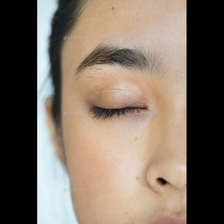

In [77]:
#@title Input URL of image to test with:
im_url = "https://s3.envato.com/files/243366163/272-AKE3518-Chim.jpg" #@param {type:"string"}

from PIL import Image

def make_square(im, min_size=256, fill_color=(0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

response = requests.get(im_url)
img = make_square(Image.open(BytesIO(response.content)))

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

size = 224, 224
img.thumbnail(size, Image.ANTIALIAS)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
# print('Input image shape:', x.shape)

preds = model.predict(x)
print('Predicted:', preds)

import operator
index, value = max(enumerate(preds[0]), key=operator.itemgetter(1))

prediction = {
    0 : "Closed",
    1 : "Open",
    2 : "Partially Closed"
}

print("Prediction:", prediction[index] + ", Confidence:", value, "\n")

for key in prediction:
  print(str(prediction[key]) + ": " + str(preds[0][key]))

img

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128   

### Get the weights

In [0]:
# weights = model.get_weights()

In [0]:
# model.set_weights(weights)

## Fine-tuning

In [0]:
model.trainable = True

set_trainable = False
for layer in model.layers:
    if 'conv_dw_13' in layer.name:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [28]:
for layer in model.layers:
    print(layer.name,layer.trainable)

input_1 False
conv1_pad False
conv1 False
conv1_bn False
conv1_relu False
conv_dw_1 False
conv_dw_1_bn False
conv_dw_1_relu False
conv_pw_1 False
conv_pw_1_bn False
conv_pw_1_relu False
conv_pad_2 False
conv_dw_2 False
conv_dw_2_bn False
conv_dw_2_relu False
conv_pw_2 False
conv_pw_2_bn False
conv_pw_2_relu False
conv_dw_3 False
conv_dw_3_bn False
conv_dw_3_relu False
conv_pw_3 False
conv_pw_3_bn False
conv_pw_3_relu False
conv_pad_4 False
conv_dw_4 False
conv_dw_4_bn False
conv_dw_4_relu False
conv_pw_4 False
conv_pw_4_bn False
conv_pw_4_relu False
conv_dw_5 False
conv_dw_5_bn False
conv_dw_5_relu False
conv_pw_5 False
conv_pw_5_bn False
conv_pw_5_relu False
conv_pad_6 False
conv_dw_6 False
conv_dw_6_bn False
conv_dw_6_relu False
conv_pw_6 False
conv_pw_6_bn False
conv_pw_6_relu False
conv_dw_7 False
conv_dw_7_bn False
conv_dw_7_relu False
conv_pw_7 False
conv_pw_7_bn False
conv_pw_7_relu False
conv_dw_8 False
conv_dw_8_bn False
conv_dw_8_relu False
conv_pw_8 False
conv_pw_8_bn False


In [0]:
# model.set_weights(weights)

In [30]:
# # Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = 5,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Epoch 1/15


W0730 02:30:09.318340 139651843925888 training.py:2050] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


70/70 [==============================] - 23s 334ms/step - loss: 0.0049 - accuracy: 0.9982 - val_loss: 2.3283e-08 - val_accuracy: 1.0000
Epoch 2/15
70/70 [==============================] - 17s 241ms/step - loss: 0.0069 - accuracy: 0.9991 - val_loss: 1.7665e-06 - val_accuracy: 1.0000
Epoch 3/15
70/70 [==============================] - 17s 242ms/step - loss: 0.0025 - accuracy: 0.9991 - val_loss: 1.9026e-08 - val_accuracy: 1.0000
Epoch 4/15
70/70 [==============================] - 17s 242ms/step - loss: 0.0060 - accuracy: 0.9969 - val_loss: 1.7296e-08 - val_accuracy: 1.0000
Epoch 5/15
70/70 [==============================] - 17s 241ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 8.7545e-08 - val_accuracy: 1.0000
Epoch 6/15
70/70 [==============================] - 17s 247ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 3.8583e-09 - val_accuracy: 1.0000
Epoch 7/15
70/70 [==============================] - 17s 244ms/step - loss: 0.0088 - accuracy: 0.9978 - val_loss: 7.4506e-09 - val

In [31]:
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

7/7 [==============================] - 6s 874ms/step - loss: 0.0000e+00 - accuracy: 1.0000
model accuracy: 1.0


## Results

In [68]:
test_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(test_dataset, val_steps)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(df_val['class'].tolist()[:len(y_pred)], y_pred), "\n")
print('Classification Report')
target_names = ["Closed", "Open", "Partially Closed"]
print(classification_report(df_val['class'].tolist()[:len(y_pred)], y_pred, target_names=target_names), "\n")

plt.matshow(confusion_matrix(df_val['class'].tolist()[:len(y_pred)], y_pred))
plt.colorbar()

W0730 03:30:15.947212 140682776315776 training_generator.py:236] Your dataset ran out of data; interrupting training. Make sure that your dataset can generate at least `steps * epochs` batches (in this case, 4 batches). You may need to use the repeat() function when building your dataset.


ValueError: ignored

## Save Model

In [0]:
model.save("./eye_blink.h5")

In [0]:
!cp eye_blink.h5 /content/drive/My\ Drive/Analytics/Misc\ Analytics/Eye-Blink\ Classifier\